In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb

In [2]:
# Läs in filen
file_path = './housing.csv'  # justera sökvägen om det behövs
housing = pd.read_csv(file_path)

# Visa grundläggande information om datasetet
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
# Skriv ut antal saknade värden per kolumn
missing_values = housing.isna().sum()
print(missing_values[missing_values > 0])

total_bedrooms    207
dtype: int64


In [4]:
# Ta bort rader med saknade värden
housing_cleaned = housing.dropna()

# Kontrollera om det finns NaN-värden kvar
print(housing_cleaned.isna().sum())

# Visa grundläggande information om det uppdaterade datasetet
housing_cleaned.info()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


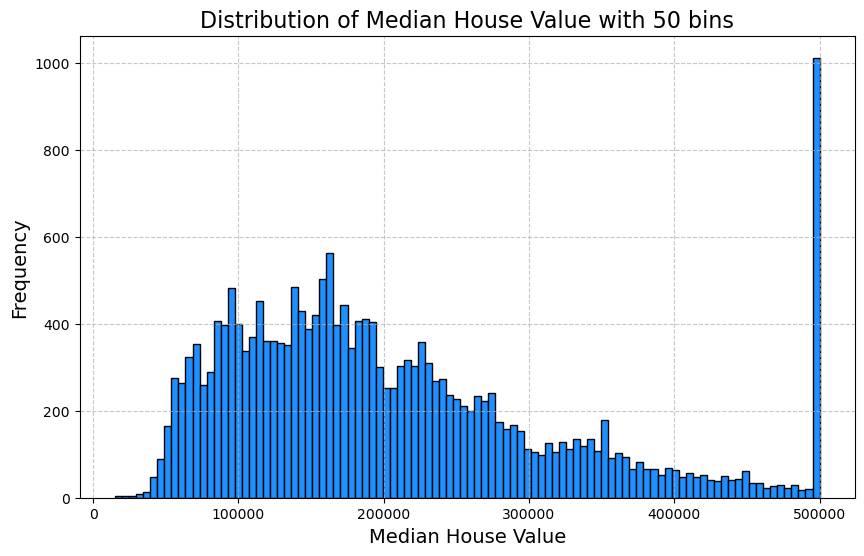

In [5]:
# Plotta distributionen av median_house_value
plt.figure(figsize=(10, 6))
plt.hist(housing['median_house_value'], bins=100, color='dodgerblue', edgecolor='black')
plt.xlabel('Median House Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Median House Value with 50 bins', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [6]:
# Räkna antalet hus med exakt värdet 500001
exact_value_count = housing[housing['median_house_value'] == 500001].shape[0]
print(f"Antal hus med exakt värdet 500001: {exact_value_count}")

# Kontrollera om det finns hus med värden nära 500001, till exempel 500000, 500002 etc.
near_value_counts = housing[housing['median_house_value'].between(499000, 501000)]
near_value_count = near_value_counts.shape[0]
print(f"Antal hus med värden mellan 499000 och 501000: {near_value_count}")

# Visa några exempel på värden nära 500001
print(near_value_counts['median_house_value'].value_counts())

Antal hus med exakt värdet 500001: 965
Antal hus med värden mellan 499000 och 501000: 994
median_house_value
500001.0    965
500000.0     27
499000.0      1
499100.0      1
Name: count, dtype: int64


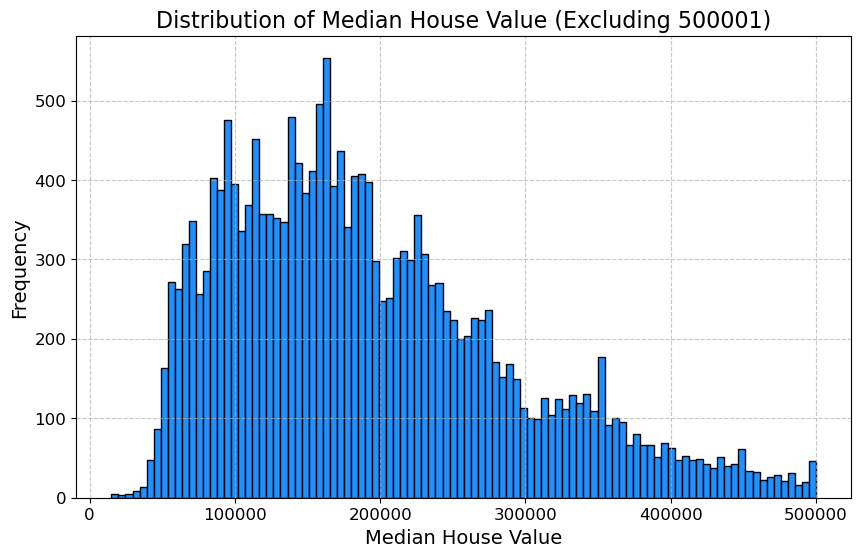

In [7]:
# Filtrera bort hus med ett värde på exakt 500001
filtered_data = housing_cleaned[housing_cleaned['median_house_value'] != 500001]

# Plotta den filtrerade distributionen
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['median_house_value'], bins=100, color='dodgerblue', edgecolor='black')
plt.xlabel('Median House Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Median House Value (Excluding 500001)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [8]:
# Visa beskrivande statistik för den filtrerade datan
filtered_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000
mean,-119.564306,35.653372,28.378074,2620.491142,539.645751,1440.290732,501.093504,3.676739,192444.651913
std,2.006241,2.150250,12.515373,2184.938093,422.413200,1144.399323,383.206416,1.569263,97702.625782
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.760000,33.930000,18.000000,1441.000000,297.000000,796.000000,282.000000,2.526500,116500.000000
50%,-118.500000,34.270000,28.000000,2111.000000,436.000000,1178.000000,411.000000,3.451900,173800.000000
75%,-117.990000,37.730000,37.000000,3118.000000,648.000000,1743.000000,606.000000,4.583300,248100.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500000.000000


In [9]:
# Räkna förekomsten av varje kategori i 'ocean_proximity'
print(filtered_data.ocean_proximity.value_counts())

ocean_proximity
<1H OCEAN     8505
INLAND        6469
NEAR OCEAN    2419
NEAR BAY      2077
ISLAND           5
Name: count, dtype: int64


In [10]:
# Omvandla 'ocean_proximity' till dummy-variabler och ta bort originalkolumnen
filtered_data = filtered_data.join(pd.get_dummies(filtered_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)

# Konvertera alla kolumner till float
filtered_data = filtered_data.astype('float64')

# Skriv ut den uppdaterade DataFrame
print(filtered_data)

# Kontrollera datatyperna
print(filtered_data.dtypes)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  media

In [11]:
# Skapa nya funktioner
filtered_data['rooms_per_household'] = filtered_data['total_rooms'] / filtered_data['households']
filtered_data['bedrooms_per_room'] = filtered_data['total_bedrooms'] / filtered_data['total_rooms']
filtered_data['population_per_household'] = filtered_data['population'] / filtered_data['households']

In [12]:
# Välj endast numeriska kolumner
numeric_data = filtered_data.select_dtypes(include=[np.number])

# Dela upp data i features och target
X = numeric_data.drop("median_house_value", axis=1)
y = numeric_data["median_house_value"]

# Formatera funktionernas namn
X.columns = X.columns.astype(str).str.replace('[', '').str.replace(']', '').str.replace('<', '').str.replace('>', '')

# Dela upp data i tränings- och testuppsättningar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skala features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Träna KNN-modellen
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
r2_knn = r2_score(y_test, y_pred_knn)
print(f"KNN R^2: {r2_knn}")

KNN R^2: 0.6811792501375917


In [14]:
# Träna Decision Tree-modellen
tree = DecisionTreeRegressor(max_depth=None)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree R^2: {r2_tree}")

Decision Tree R^2: 0.5827762184584864


In [15]:
# Träna SVR-modellen
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"SVR R^2: {r2_svr}")

SVR R^2: -0.03136815857337427


In [16]:
# Träna AdaBoost-modellen
adaboost = AdaBoostRegressor(n_estimators=50)
adaboost.fit(X_train, y_train)
y_pred_ada = adaboost.predict(X_test)
r2_ada = r2_score(y_test, y_pred_ada)
print(f"AdaBoost R^2: {r2_ada}")

AdaBoost R^2: 0.38338917206547274


In [17]:
# Träna XGBoost-modellen
xgboost = xgb.XGBRegressor(n_estimators=100)
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost R^2: {r2_xgb}")

XGBoost R^2: 0.8143400478916538


In [18]:
# Träna Neural Network-modellen
nn = MLPRegressor(hidden_layer_sizes=(100,), max_iter=2000)
nn.fit(X_train_scaled, y_train)
y_pred_nn = nn.predict(X_test_scaled)
r2_nn = r2_score(y_test, y_pred_nn)
print(f"Neural Network R^2: {r2_nn}")

Neural Network R^2: 0.6742080704532372


C:\Users\pauls\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
# Skapa en LightGBM-modell
lgb_model = lgb.LGBMRegressor(n_estimators=100)

# Träna modellen
lgb_model.fit(X_train_scaled, y_train)

# Förutsäg med modellen
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Utvärdera modellen
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f"LightGBM R^2: {r2_lgb}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2615
[LightGBM] [Info] Number of data points in the train set: 15580, number of used features: 15
[LightGBM] [Info] Start training from score 192150.461874
LightGBM R^2: 0.8146655222236894


KNN R^2: 0.6811792501375917
Decision Tree R^2: 0.5827762184584864
SVR R^2: -0.03136815857337427
AdaBoost R^2: 0.38338917206547274
XGBoost R^2: 0.8143400478916538
Neural Network R^2: 0.6742080704532372
LightGBM R^2: 0.8146655222236894


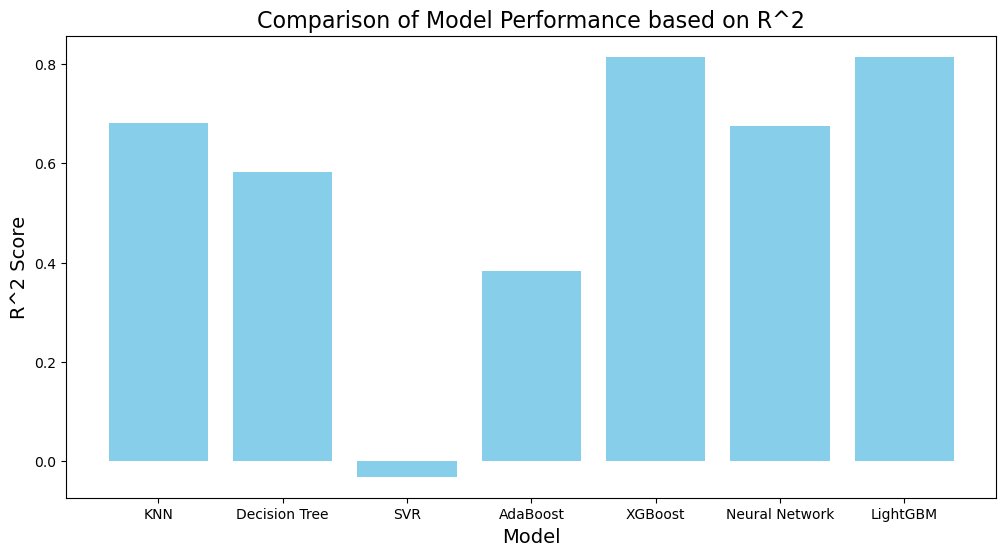

In [20]:
# Samla resultaten
results = {
    'KNN': r2_knn,
    'Decision Tree': r2_tree,
    'SVR': r2_svr,
    'AdaBoost': r2_ada,
    'XGBoost': r2_xgb,
    'Neural Network': r2_nn,
    'LightGBM': r2_lgb
}

# Skriv ut resultaten
for model, r2 in results.items():
    print(f"{model} R^2: {r2}")

# Plotta jämförelsen
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.xlabel('Model', fontsize=14)
plt.ylabel('R^2 Score', fontsize=14)
plt.title('Comparison of Model Performance based on R^2', fontsize=16)
plt.show()

In [21]:
# Definiera parametergitter för SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Skapa en SVR-modell
svr = SVR()

# Skapa en GridSearchCV för att söka efter de bästa hyperparametrarna
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Träna GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Skriv ut de bästa hyperparametrarna och resultatet
print("Best parameters found: ", grid_search.best_params_)
print("Best estimator R^2: ", r2_score(y_test, grid_search.best_estimator_.predict(X_test_scaled)))

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found:  {'C': 100, 'epsilon': 0.01, 'kernel': 'linear'}
Best estimator R^2:  0.6014692732089864


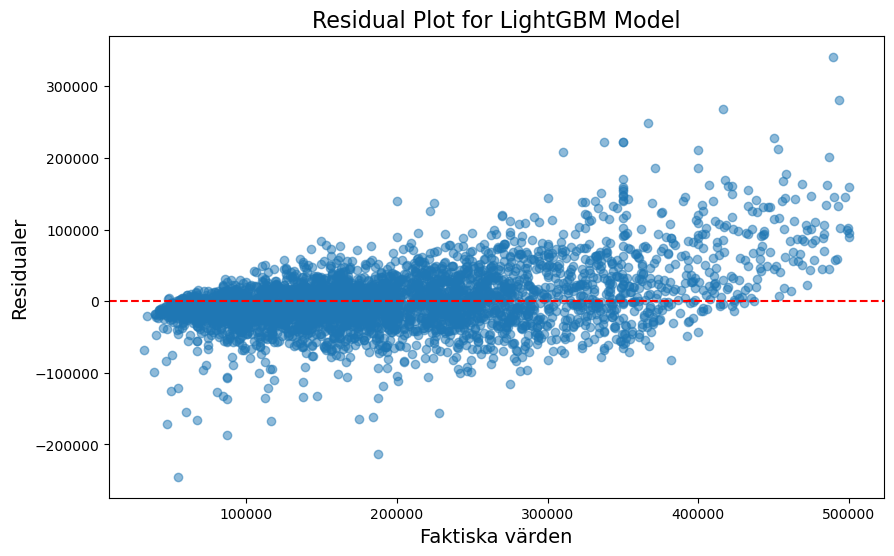

In [22]:
# Prediktera med LightGBM-modellen
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Beräkna residualer
residuals = y_test - y_pred_lgb

# Plotta residualerna
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel('Faktiska värden', fontsize=14)
plt.ylabel('Residualer', fontsize=14)
plt.title('Residual Plot for LightGBM Model', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

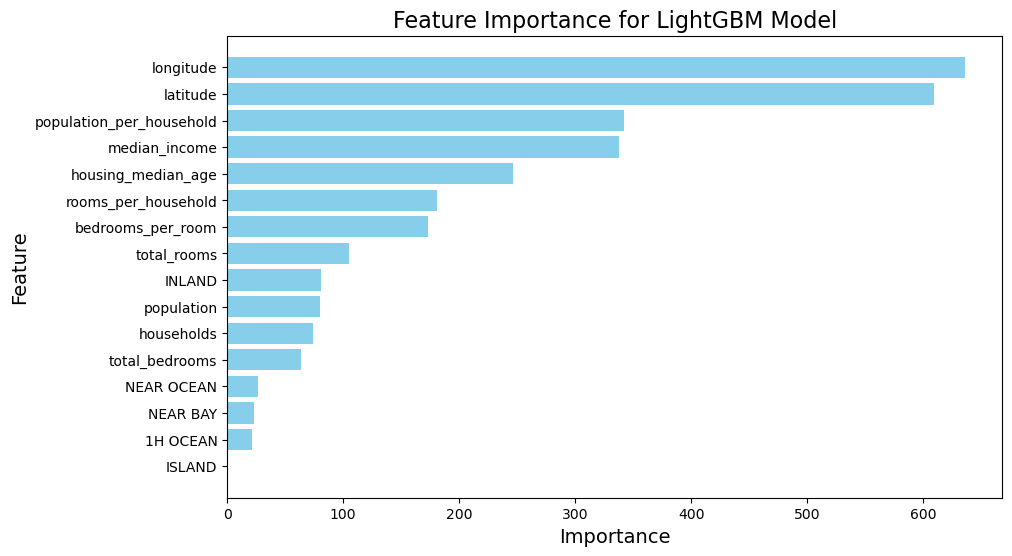

In [23]:
# Hämta feature importance
feature_importance = lgb_model.feature_importances_
features = X.columns

# Skapa en DataFrame för feature importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sortera DataFrame efter importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotta feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance for LightGBM Model', fontsize=16)
plt.gca().invert_yaxis()
plt.show()

KNN RMSE: 55567.98098536831, RRMSE: 28.699295388988737%
Decision Tree RMSE: 63161.721437047156, RRMSE: 32.62124821983621%
SVR RMSE: 62127.26474552628, RRMSE: 32.08698050611649%
AdaBoost RMSE: 66068.62364220986, RRMSE: 34.12258124604126%
XGBoost RMSE: 42404.35336737554, RRMSE: 21.900652884793733%


C:\Users\pauls\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network RMSE: 56036.3350322422, RRMSE: 28.941187048529173%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2615
[LightGBM] [Info] Number of data points in the train set: 15580, number of used features: 15
[LightGBM] [Info] Start training from score 192150.461874
LightGBM RMSE: 42367.1682273127, RRMSE: 21.88144780842025%

RMSE Results:
KNN RMSE: 55567.98098536831
Decision Tree RMSE: 63161.721437047156
SVR (Best) RMSE: 62127.26474552628
AdaBoost RMSE: 66068.62364220986
XGBoost RMSE: 42404.35336737554
Neural Network RMSE: 56036.3350322422
LightGBM RMSE: 42367.1682273127

RRMSE Results:
KNN RRMSE: 28.699295388988737%
Decision Tree RRMSE: 32.62124821983621%
SVR (Best) RRMSE: 32.08698050611649%
AdaBoost RRMSE: 34.12258124604126%
XGBoost RRMSE: 21.900652884793733%
Neural Network RRMSE: 28.941187048529173%
LightGBM RRMSE: 21.88144780842025%


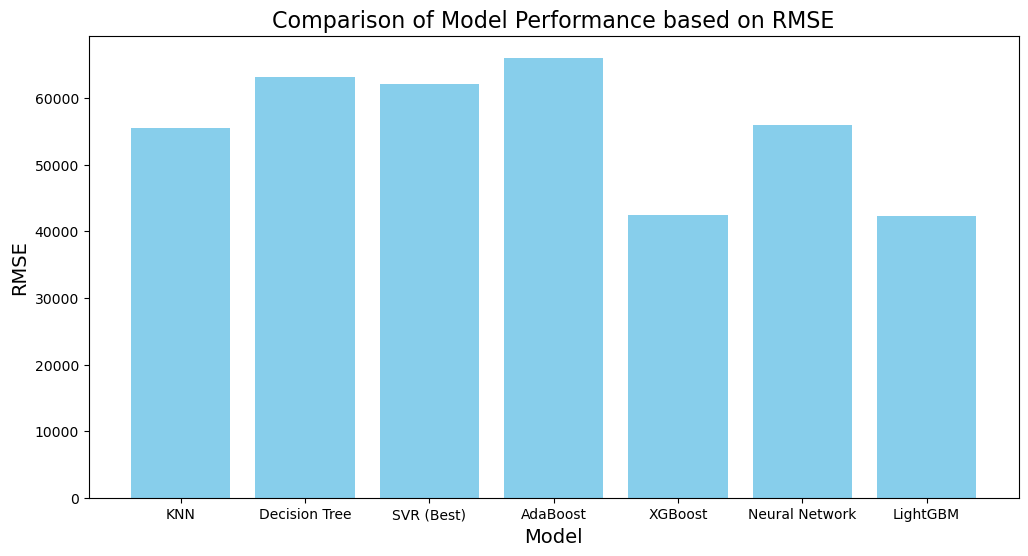

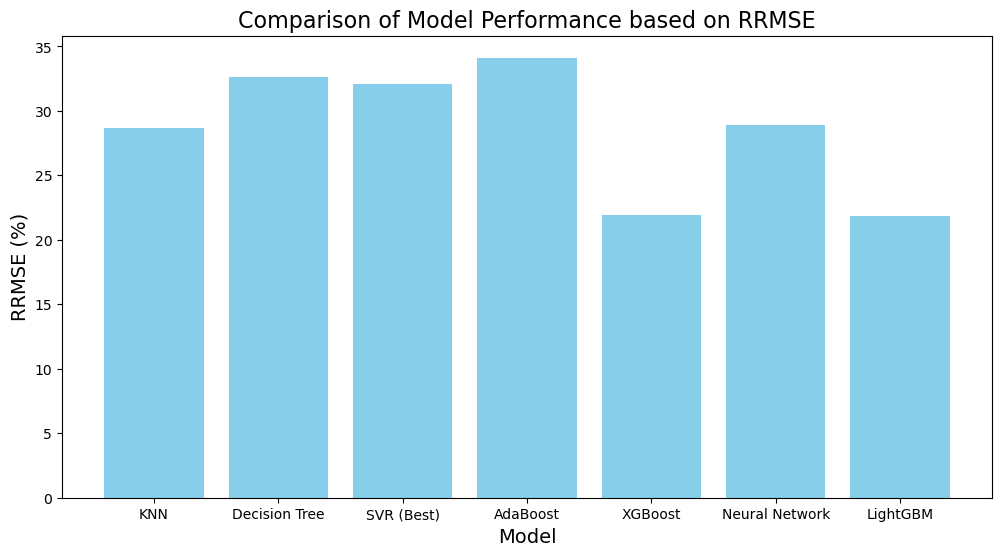

In [24]:
# Funktion för att beräkna RRMSE
def calculate_rrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rrmse = (rmse / np.mean(y_true)) * 100
    return rmse, rrmse

# KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
rmse_knn, rrmse_knn = calculate_rrmse(y_test, y_pred_knn)
print(f"KNN RMSE: {rmse_knn}, RRMSE: {rrmse_knn}%")

# Decision Tree
tree = DecisionTreeRegressor(max_depth=None)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
rmse_tree, rrmse_tree = calculate_rrmse(y_test, y_pred_tree)
print(f"Decision Tree RMSE: {rmse_tree}, RRMSE: {rrmse_tree}%")

# SVR med bästa parametrarna från GridSearchCV
svr_best = SVR(C=100, epsilon=0.01, kernel='linear')
svr_best.fit(X_train_scaled, y_train)
y_pred_svr_best = svr_best.predict(X_test_scaled)
rmse_svr, rrmse_svr = calculate_rrmse(y_test, y_pred_svr_best)
print(f"SVR RMSE: {rmse_svr}, RRMSE: {rrmse_svr}%")

# AdaBoost
adaboost = AdaBoostRegressor(n_estimators=50)
adaboost.fit(X_train, y_train)
y_pred_ada = adaboost.predict(X_test)
rmse_ada, rrmse_ada = calculate_rrmse(y_test, y_pred_ada)
print(f"AdaBoost RMSE: {rmse_ada}, RRMSE: {rrmse_ada}%")

# XGBoost
xgboost = xgb.XGBRegressor(n_estimators=100)
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)
rmse_xgb, rrmse_xgb = calculate_rrmse(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb}, RRMSE: {rrmse_xgb}%")

# Neural Network
nn = MLPRegressor(hidden_layer_sizes=(100,), max_iter=2000)
nn.fit(X_train_scaled, y_train)
y_pred_nn = nn.predict(X_test_scaled)
rmse_nn, rrmse_nn = calculate_rrmse(y_test, y_pred_nn)
print(f"Neural Network RMSE: {rmse_nn}, RRMSE: {rrmse_nn}%")

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100)
lgb_model.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_model.predict(X_test_scaled)
rmse_lgb, rrmse_lgb = calculate_rrmse(y_test, y_pred_lgb)
print(f"LightGBM RMSE: {rmse_lgb}, RRMSE: {rrmse_lgb}%")

# Samla RMSE- och RRMSE-resultaten
rmse_results = {
    'KNN': rmse_knn,
    'Decision Tree': rmse_tree,
    'SVR (Best)': rmse_svr,
    'AdaBoost': rmse_ada,
    'XGBoost': rmse_xgb,
    'Neural Network': rmse_nn,
    'LightGBM': rmse_lgb
}

rrmse_results = {
    'KNN': rrmse_knn,
    'Decision Tree': rrmse_tree,
    'SVR (Best)': rrmse_svr,
    'AdaBoost': rrmse_ada,
    'XGBoost': rrmse_xgb,
    'Neural Network': rrmse_nn,
    'LightGBM': rrmse_lgb
}

# Skriv ut alla RMSE- och RRMSE-resultat
print("\nRMSE Results:")
for model, rmse in rmse_results.items():
    print(f"{model} RMSE: {rmse}")

print("\nRRMSE Results:")
for model, rrmse in rrmse_results.items():
    print(f"{model} RRMSE: {rrmse}%")

# Plotta RMSE-jämförelsen
plt.figure(figsize=(12, 6))
plt.bar(rmse_results.keys(), rmse_results.values(), color='skyblue')
plt.xlabel('Model', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('Comparison of Model Performance based on RMSE', fontsize=16)
plt.show()

# Plotta RRMSE-jämförelsen
plt.figure(figsize=(12, 6))
plt.bar(rrmse_results.keys(), rrmse_results.values(), color='skyblue')
plt.xlabel('Model', fontsize=14)
plt.ylabel('RRMSE (%)', fontsize=14)
plt.title('Comparison of Model Performance based on RRMSE', fontsize=16)
plt.show()

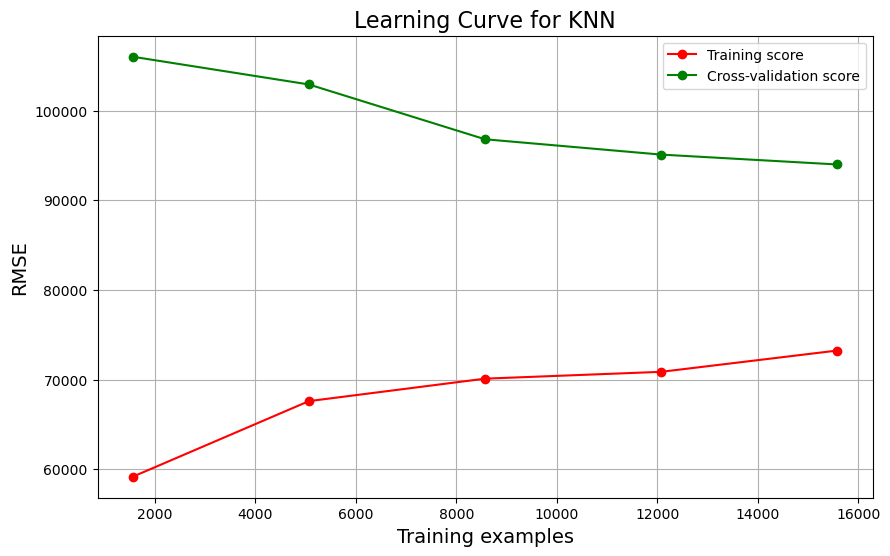

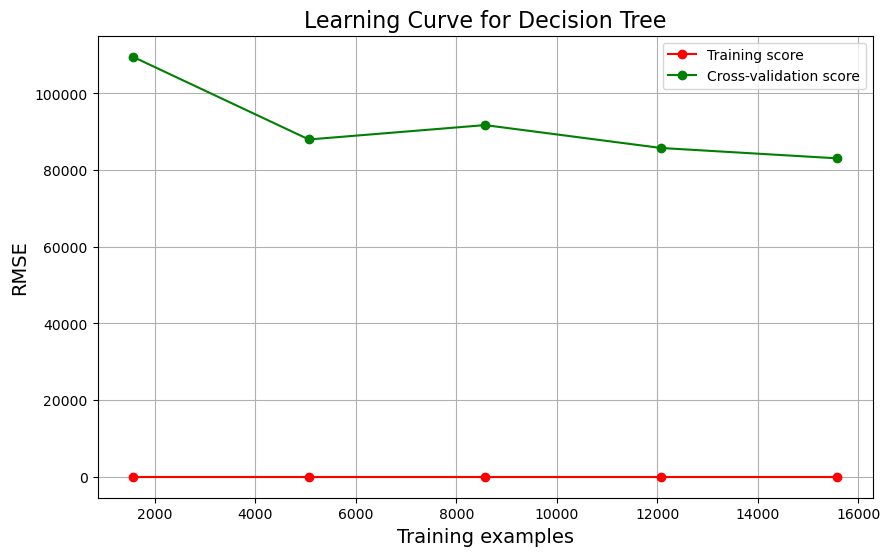

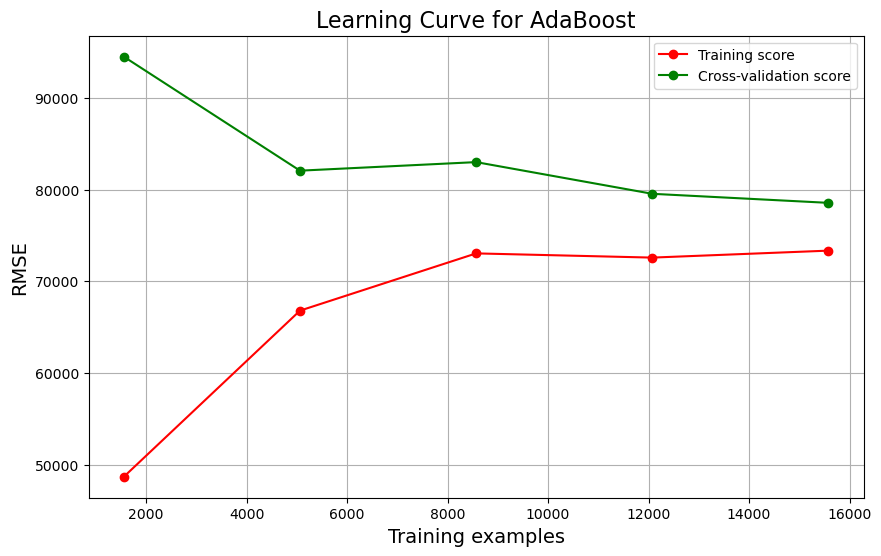

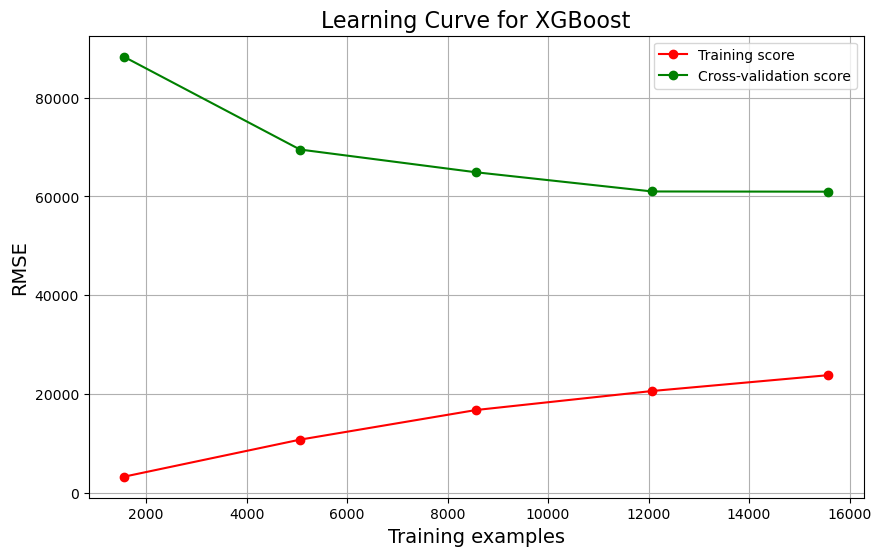

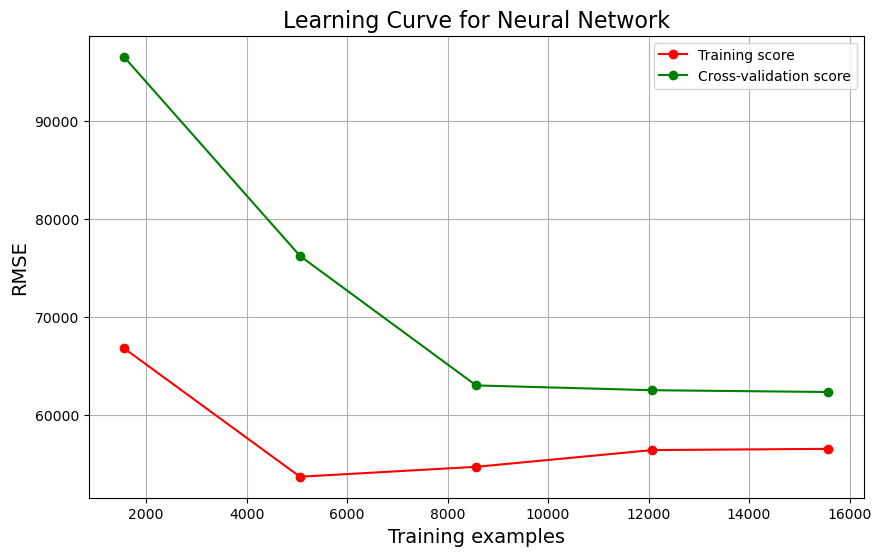

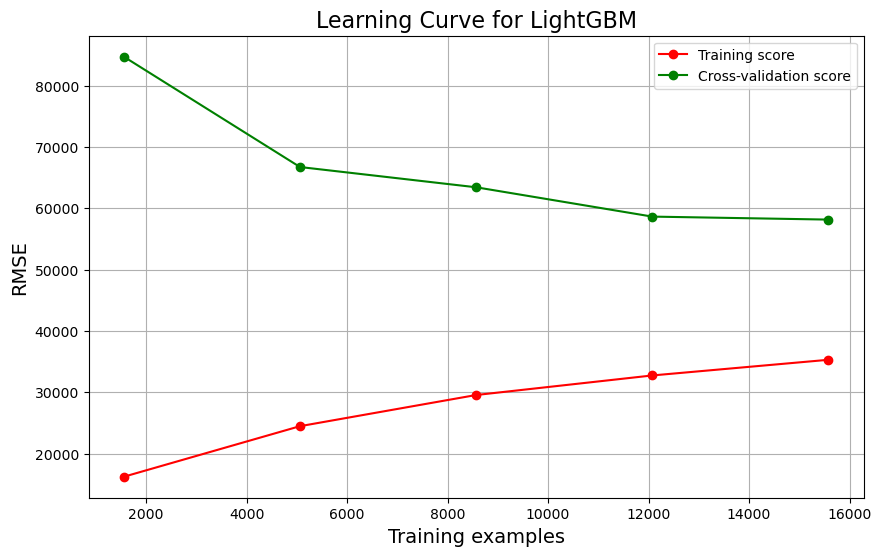

In [25]:
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = np.sqrt(-train_scores).mean(axis=1)
    test_scores_mean = np.sqrt(-test_scores).mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training examples', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.title(f'Learning Curve for {model_name}', fontsize=16)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curves for selected models
plot_learning_curve(KNeighborsRegressor(n_neighbors=5), X, y, 'KNN')
plot_learning_curve(DecisionTreeRegressor(max_depth=None), X, y, 'Decision Tree')
#plot_learning_curve(SVR(C=100, epsilon=0.01, kernel='linear'), X, y, 'SVR (Best)')
plot_learning_curve(AdaBoostRegressor(n_estimators=50), X, y, 'AdaBoost')
plot_learning_curve(xgb.XGBRegressor(n_estimators=100), X, y, 'XGBoost')
plot_learning_curve(MLPRegressor(hidden_layer_sizes=(100,), max_iter=2000), X, y, 'Neural Network')
plot_learning_curve(lgb.LGBMRegressor(n_estimators=100), X, y, 'LightGBM')

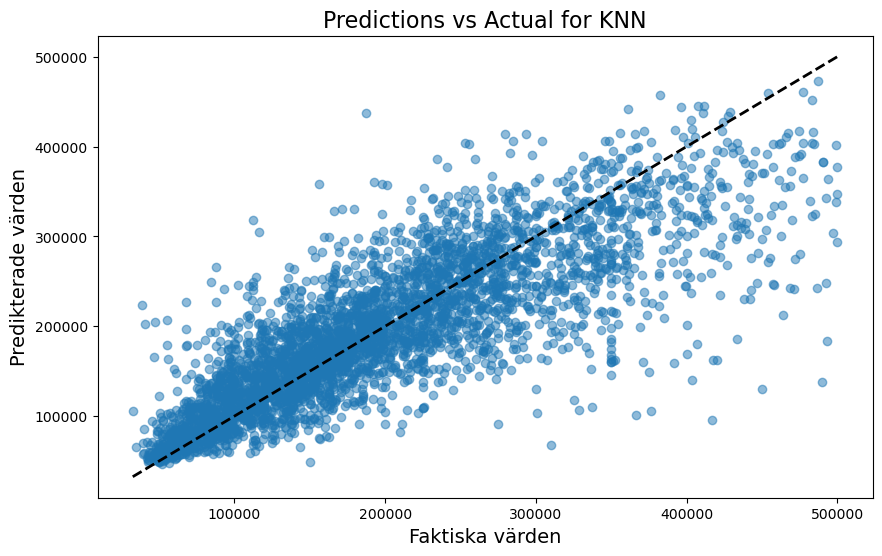

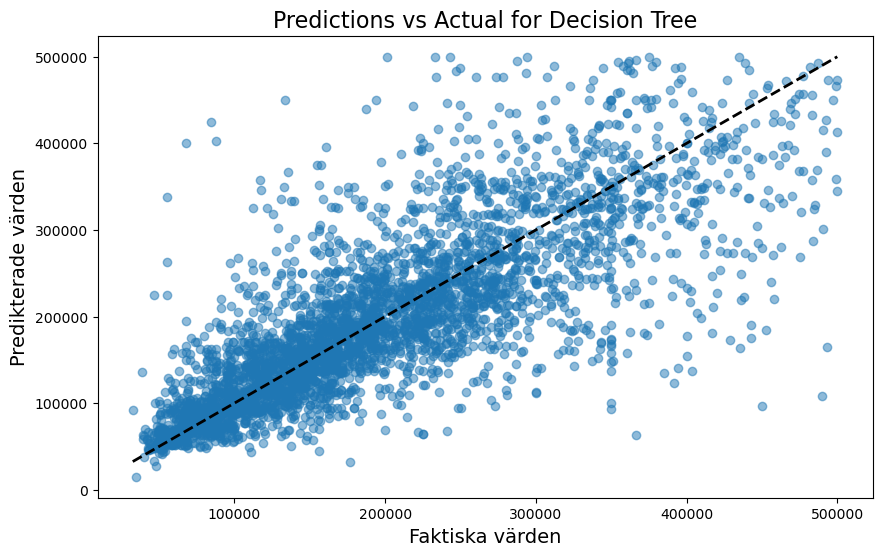

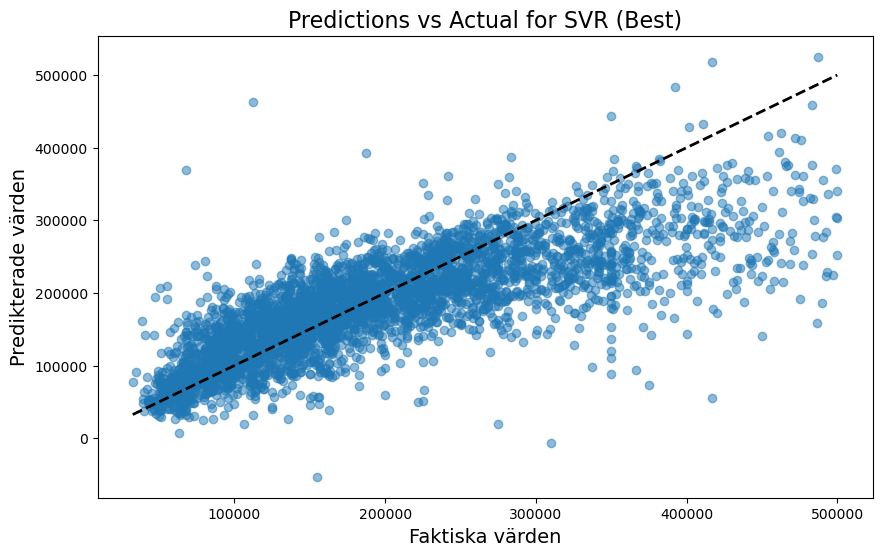

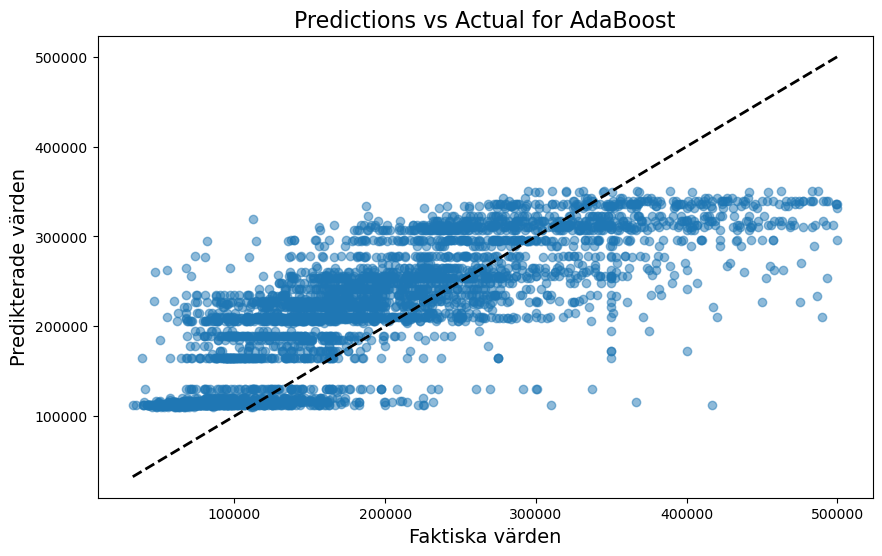

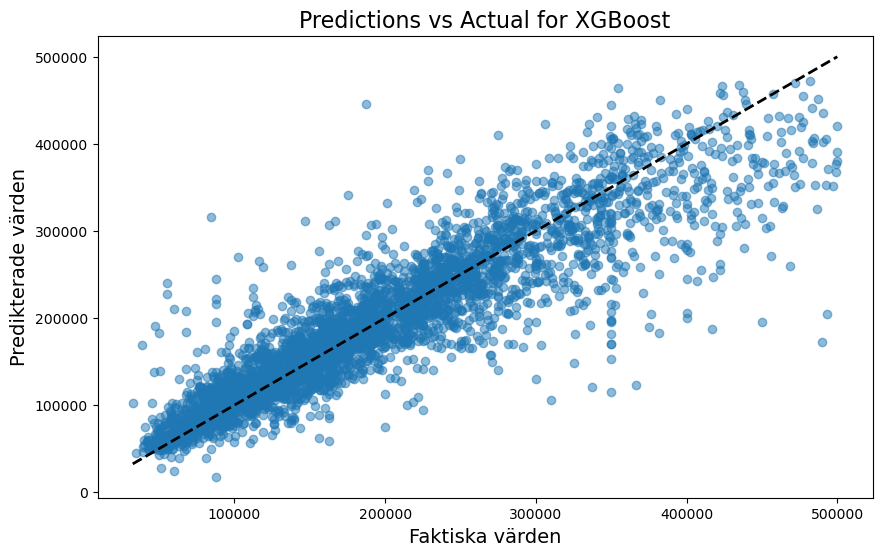

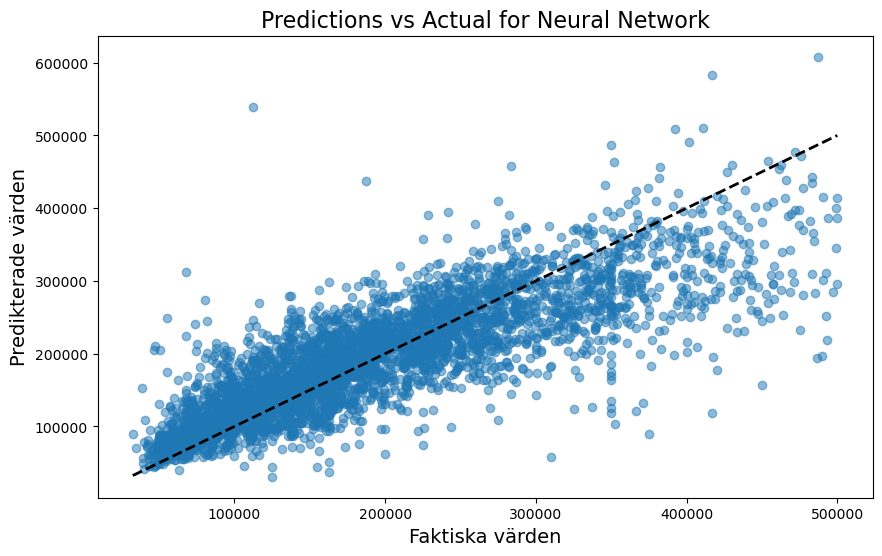

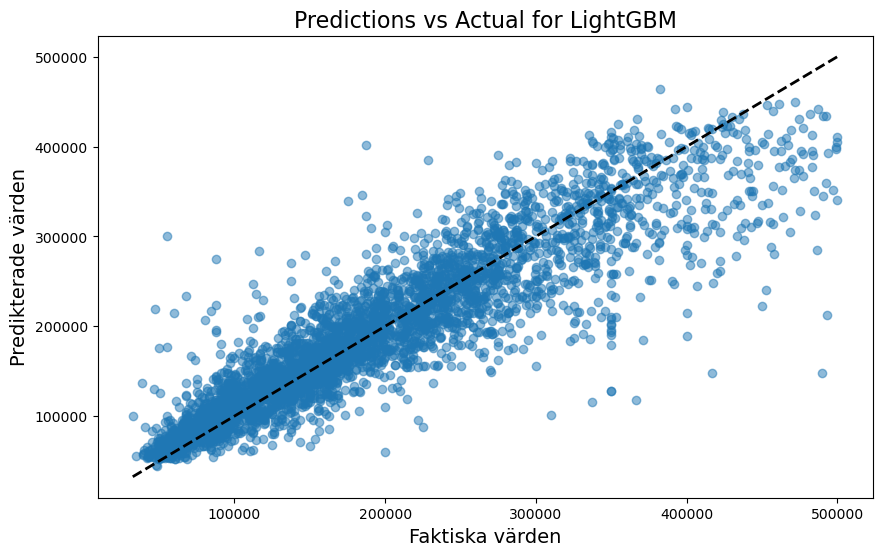

In [26]:
def plot_predictions_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel('Faktiska värden', fontsize=14)
    plt.ylabel('Predikterade värden', fontsize=14)
    plt.title(f'Predictions vs Actual for {model_name}', fontsize=16)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.show()

# Plot predictions vs actual for all models
plot_predictions_vs_actual(y_test, y_pred_knn, 'KNN')
plot_predictions_vs_actual(y_test, y_pred_tree, 'Decision Tree')
plot_predictions_vs_actual(y_test, y_pred_svr_best, 'SVR (Best)')
plot_predictions_vs_actual(y_test, y_pred_ada, 'AdaBoost')
plot_predictions_vs_actual(y_test, y_pred_xgb, 'XGBoost')
plot_predictions_vs_actual(y_test, y_pred_nn, 'Neural Network')
plot_predictions_vs_actual(y_test, y_pred_lgb, 'LightGBM')
